<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M1_Recommender_System_Nomadlis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a Recommender System in Python



In today's information age, we are bombarded with choices. We have access to millions of products, movies, music, and articles, but it can be overwhelming to know where to start. Recommender systems help us to navigate this information overload by providing us with personalized recommendations based on our interests and past behavior.



####**Question 1: What Are the Different Types of Recommender Systems?**

Recommender systems can be broadly categorized into the following types, each with its own advantages and disadvantages:

- Collaborative Filtering:
  *   User-Based: Recommends items based on the similarities between users. If Alice and Bob like the same movies, then the movies liked by Alice will be recommended to Bob and vice versa.
  *   Item-Based: Recommends items that are similar to a given item. For example, if you liked the movie "Inception," you might also like other sci-fi thrillers.


- Content-Based Filtering:
   - Recommends items by comparing the content of the items and a user profile, with content described in terms of several descriptors or terms that are inherent to the item.


![image.png](https://raw.githubusercontent.com/aaubs/ds-master/main/data/recommendation_sys_1.png)

##Step 1: Data Preprocessing
###1.1 Load Data
The first step in any data analysis or machine learning project is to load the data. We'll use the Pandas library for this purpose. We've already loaded the data, but let's do it again for the sake of the tutorial.

Here's how you can load a CSV file using Pandas:

In [49]:
import pandas as pd

df_trips = pd.read_csv('https://sds-aau.github.io/SDS-master/M1/data/trips.csv')

###1.2 Handle Missing Values
Before we proceed, it's crucial to handle any missing values in the dataset. Missing values can affect the performance and reliability of the model. Let's check for missing values and handle them appropriately.

In [50]:
# Check for missing values
df_trips.isnull().sum()

Unnamed: 0        0
username          0
country          37
country_code    601
country_slug     37
date_end        175
date_start        0
latitude          0
longitude         0
place             0
place_slug       37
dtype: int64

If any columns have missing values, you can choose to either remove those rows or fill them with a specific value, such as the mean or median.

###1.3 Convert Date Columns to DateTime Objects
For easier manipulation and analysis, it's beneficial to convert date columns into DateTime objects.

In [51]:
# Convert date columns to DateTime objects

df_trips['date_start'] = pd.to_datetime(df_trips['date_start'], errors='coerce')
df_trips['date_end'] = pd.to_datetime(df_trips['date_end'], errors='coerce')

###1.4 Data Exploration
After cleaning the data, it's helpful to perform some initial exploratory data analysis (EDA) to understand the dataset's characteristics.


For example, you could use .describe() to get summary statistics or .value_counts() to understand the distribution of categorical variables.

In [52]:
# Summary statistics

df_trips.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,46510.0,23254.500000,13426.424847,0.0,11627.25,23254.5,34881.75,46509.0
latitude,46510.0,28.931477,23.551976,-79.0,14.00,37.0,47.00,78.0
longitude,46510.0,11.912750,78.767316,-175.0,-68.00,9.0,98.00,178.0


In [53]:
# Distribution of trips by country
df_trips['country'].value_counts()

United States     7573
Thailand          3372
United Kingdom    2230
Germany           2019
Spain             1975
                  ... 
Palau                1
Sanur                1
Andaman Sea          1
Algeria              1
Spania               1
Name: country, Length: 249, dtype: int64

Nearest Neighbors (KNN) imputation is a suitable method of handling missing data. It works by finding the k nearest neighbors to a given sample with missing values and then imputing those missing values based on the neighbors.

To perform KNN imputation, we'll use the KNNImputer class from scikit-learn's impute module. Given that KNN is computationally expensive, we should select only the columns that are essential for the imputation.

Let's proceed with the KNN imputation.

In [54]:
from sklearn.impute import KNNImputer
import numpy as np

# Selecting columns that are essential for the imputation
# In our case, let's select numerical columns like 'latitude' and 'longitude'
columns_to_impute = ['latitude', 'longitude']

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform imputation
df_trips[columns_to_impute] = knn_imputer.fit_transform(df_trips[columns_to_impute])

# Check if any missing values are remaining
df_trips[columns_to_impute].isnull().sum()


latitude     0
longitude    0
dtype: int64

The KNN imputation was successful, and there are no more missing values in the latitude and longitude columns.

Note: We didn't impute the missing values for the categorical columns and date columns because KNN imputation is generally not suitable for such types of data. For those, you might want to use different imputation methods like filling with the most frequent value or using specialized techniques for temporal data.

##Step 2: Feature Engineering
###2.1 Create New Features
Often, the raw data may not provide all the information you need. Feature engineering involves transforming the existing features or creating new ones to better represent the underlying problem to the machine learning models. In the context of a recommender system, you might consider creating features like:

Duration of stay
Distance traveled from one place to another
For now, let's create a feature for the "Duration of Stay":


**Duration of Stay** = **Date End** − **Date Start**

Let's go ahead and create this new feature.

In [55]:
# Creating a new feature for the 'Duration of Stay'

df_trips['duration_of_stay'] = (df_trips['date_end'] - df_trips['date_start']).dt.days

We've successfully added a new feature called duration_of_stay, which represents the duration of each trip in days.

##Step 3: Build a Simple Recommender System
Now that we have cleaned and preprocessed the data, let's move on to building a recommender system.

### 3.1. Label Encoding and Matrix Creation
This part label-encodes the usernames and place slugs, creating numerical IDs for each. It then builds a sparse matrix to capture the interactions between users and places.

In [56]:
import scipy.sparse as ss
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [57]:
# Initialize label encoders

le_user = LabelEncoder()
le_place = LabelEncoder()

In [58]:
# Label encode usernames and place slugs

df_trips['username_id'] = le_user.fit_transform(df_trips['username'])
df_trips['place_slug_id'] = le_place.fit_transform(df_trips['place_slug'])

In [59]:
df_trips.shape

(46510, 14)

####**Question 2: Why Do We Use Sparse Matrices in Recommender Systems?**

In the context of recommender systems, particularly those dealing with user-item interactions, sparse matrices play a crucial role. They are an efficient way to represent large matrices that are mostly populated with zero values. Sparse matrices are memory-efficient, computationally efficient, and scalable.

- **Memory Efficiency:** Sparse matrices store only the non-zero elements and their indices, which saves a significant amount of memory.

- **Computational Efficiency:** Certain matrix operations can be executed faster using sparse matrices, as they are optimized to ignore zero elements.

- **Scalability:** As your data grows, using dense matrices could become impractical due to memory limitations. Sparse matrices allow your system to scale more easily.

In this notebook, we use the **coo_matrix from SciPy's sparse package** to represent the user-item interaction matrix. This representation allows us to efficiently store and manipulate the data.

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/recommendation_sys_2.png)

In [112]:
# Create a sparse matrix

# Create an array of ones, with length equal to the number of rows in the DataFrame
ones = np.ones(len(df_trips), np.uint32)

# Create the sparse matrix using the 'username_id' and 'place_slug_id' columns as indices
matrix = ss.coo_matrix((ones, (df_trips['username_id'], df_trips['place_slug_id'])))

In [113]:
matrix.shape

(2871, 961)

### 3.2. Perform Dimensionality Reduction
This section uses Truncated Singular Value Decomposition (SVD) to reduce the dimensionality of the user-item interaction matrix.

####**Question 3: Why Is Dimensionality Reduction Important in Recommender Systems?**

Dimensionality reduction is a critical aspect of building efficient and effective recommender systems for several reasons:

- **Computational Efficiency:** Reducing the number of dimensions can significantly speed up algorithmic computations and save storage space, making the system more scalable.


- **Latent Feature Discovery:** Techniques like Singular Value Decomposition (SVD) can uncover hidden features that capture the underlying structure of the data more effectively than the original high-dimensional features.


In [61]:
np.where(matrix.todense()[1] == 1)

(array([0, 0]), array([452, 824]))

In [62]:
df_trips[df_trips['username_id'] == 1]

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,duration_of_stay,username_id,place_slug_id
699,699,@0chucha0,Sri Lanka,LK,sri-lanka,2018-03-18,2018-02-18,7.0,80.0,Sri Lanka,sri-lanka,28.0,1,824
700,700,@0chucha0,Thailand,TH,thailand,2018-02-20,2017-11-21,9.0,100.0,Ko Samui,ko-samui-thailand,91.0,1,452


In [63]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [64]:
matrix_places = svd.fit_transform(matrix.T)
matrix_places.shape

(961, 5)

### 3.3. Calculate The Similarity Matrix


A cosine distance matrix of item or user is a table that shows how similar each item or user is to every other item or user, based on their cosine similarity. Here, we can decide which type of collaborative model to implement, based on our specific needs and goals.

####3.3.1. Item-Based Collaborative Filtering
Recommends items based on their similarity to items that the target user has interacted with. This is generally more scalable and can handle a larger item set. It also performs better for new users but may not be as personalized as user-based models.

In [65]:
from sklearn.metrics.pairwise import cosine_distances

In [66]:
cosine_distance_matrix_places = cosine_distances(matrix_places)
cosine_distance_matrix_places.shape

(961, 961)

In [67]:
cosine_distance_matrix_places

array([[0.        , 0.93737257, 0.94042055, ..., 0.55101577, 0.94479183,
        0.66700793],
       [0.93737257, 0.        , 0.2219977 , ..., 0.55865144, 1.01683665,
        0.55894041],
       [0.94042055, 0.2219977 , 0.        , ..., 0.42547908, 0.90915149,
        0.12785817],
       ...,
       [0.55101577, 0.55865144, 0.42547908, ..., 0.        , 0.35913659,
        0.36126287],
       [0.94479183, 1.01683665, 0.90915149, ..., 0.35913659, 0.        ,
        0.89817704],
       [0.66700793, 0.55894041, 0.12785817, ..., 0.36126287, 0.89817704,
        0.        ]])

In [68]:
le_place.transform(['ubud-bali-indonesia'])

array([891])

In [69]:
df_trips[df_trips.place_slug_id == 891]

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,duration_of_stay,username_id,place_slug_id
79,79,@jezfx,Indonesia,ID,indonesia,2019-05-01,2018-11-25,-8.0,115.0,Ubud,ubud-bali-indonesia,157.0,1204,891
196,196,@adventureinmyveins,Indonesia,ID,indonesia,2017-04-03,2017-03-03,-8.0,115.0,Ubud,ubud-bali-indonesia,31.0,51,891
354,354,@gnefkow,Indonesia,ID,indonesia,2017-07-12,2017-06-13,-8.0,115.0,Ubud,ubud-bali-indonesia,29.0,908,891
417,417,@marcusmeurer,Indonesia,ID,indonesia,2016-04-19,2016-04-03,-8.0,115.0,Ubud,ubud-bali-indonesia,16.0,1644,891
546,546,@laudowicz,Indonesia,ID,indonesia,2015-12-28,2015-12-19,-8.0,115.0,Ubud,ubud-bali-indonesia,9.0,1495,891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46007,46007,@reustle,Indonesia,ID,indonesia,2016-12-05,2016-11-07,-8.0,115.0,Ubud,ubud-bali-indonesia,28.0,2187,891
46070,46070,@reustle,Indonesia,ID,indonesia,2015-04-24,2015-03-27,-8.0,115.0,Ubud,ubud-bali-indonesia,28.0,2187,891
46151,46151,@amurzaya,Indonesia,ID,indonesia,2018-02-14,2018-01-24,-8.0,115.0,Ubud,ubud-bali-indonesia,21.0,143,891
46285,46285,@cw,Indonesia,ID,indonesia,2016-02-26,2016-01-28,-8.0,115.0,Ubud,ubud-bali-indonesia,29.0,555,891


In [70]:
np.argsort(cosine_distance_matrix_places[891,:])[:5]

array([891, 244, 450, 676, 803])

Finally, we recommend items that these similar users have interacted with but the target user has not.

In [71]:
le_place.inverse_transform(np.argsort(cosine_distance_matrix_places[858,:])[:10])

array(['tel-aviv-israel', 'dakar-senegal', 'israel',
       'santo-domingo-dominican-republic', 'braga-portugal',
       'palma-mallorca-spain', 'tartu-estonia', 'saint-lucia',
       'strasbourg-france', 'bordeaux-france'], dtype=object)

In [72]:
def find_similar_places(place, num_similar):
    # Convert the place name to its corresponding numerical index
    place_index = le_place.transform([place])[0]

    # Retrieve the cosine distances for this place from the matrix
    distances = cosine_distance_matrix_places[place_index, :]

    # Get indices of num_similar smallest distances
    closest_indices = np.argsort(distances)[:num_similar]

    # Convert these indices back to place names
    closest_places = le_place.inverse_transform(closest_indices)

    return closest_places

In [73]:
find_similar_places('ko-pha-ngan-thailand', 10)

array(['ko-pha-ngan-thailand', 'ubud-bali-indonesia', 'darwin-australia',
       'vietnam', 'ho-chi-minh-city-vietnam', 'canberra-australia',
       'siem-reap-cambodia', 'phnom-penh-cambodia', 'delhi-india',
       'taipei-taiwan'], dtype=object)

In [74]:
def find_similar_multiplaces(places, num_similar):
    # Transform place names to their corresponding numerical indices
    places_indices = le_place.transform(places)

    # Compute the average vector representation of the given places
    avg_vector = np.mean(matrix_places[places_indices], axis=0).reshape(1, -1)

    # Calculate cosine distances between the average vector and all place vectors in the matrix
    distances = cosine_distances(avg_vector, matrix_places)[0]

    # Find the indices of 'num_similar' most similar places
    closest_indices = np.argsort(distances)[:num_similar]

    # Convert numerical indices back to place names
    return le_place.inverse_transform(closest_indices)


In [75]:
find_similar_multiplaces(['lviv-ukraine','darwin-australia'], 20)

array(['siem-reap-cambodia', 'lviv-ukraine', 'ho-chi-minh-city-vietnam',
       'yogyakarta-indonesia', 'phnom-penh-cambodia', 'shenyang-china',
       'sinuiju-north-korea', 'north-korea', 'guiyang-china', 'indonesia',
       'taipei-taiwan', 'kuala-lumpur-malaysia', 'krabi-thailand',
       'darwin-australia', 'laos', 'gurgaon-india', 'ko-lanta-thailand',
       'ubud-bali-indonesia', 'riga-latvia',
       'road-town-british-virgin-islands'], dtype=object)

####3.3.2. User-Based Collaborative Filtering

Recommends items by finding users who are similar to the target user. If user A is similar to user B, then the items liked by user B can be recommended to user A.

####**Question 4: What is the main difference between item-based and user-based recommender systems?**

Item-based recommender systems focus on recommending travel destinations based on similarities between the destinations themselves, while user-based recommender systems make recommendations based on similarities between users' past behaviors and preferences. Item-based is generally good for new users, whereas user-based provides more personalized recommendations but may struggle with new users.







In [76]:
df_trips[df_trips.username_id == 7]

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,duration_of_stay,username_id,place_slug_id
44611,44611,@9102180,Indonesia,ID,indonesia,2018-01-31,2018-01-14,-8.0,115.0,Canggu,canggu-bali-indonesia,17.0,7,167
44612,44612,@9102180,Thailand,TH,thailand,2018-01-13,2017-12-01,13.0,100.0,Bangkok,bangkok-thailand,43.0,7,78
44613,44613,@9102180,Thailand,TH,thailand,2017-09-30,2017-08-14,18.0,98.0,Chiang Mai,chiang-mai-thailand,47.0,7,191


In [77]:
user_places_ids = df_trips[df_trips.username_id == 7]['place_slug_id'].unique()
user_places_ids

array([167,  78, 191])

In [78]:
matrix_places.shape

(961, 5)

In [79]:
matrix_places[user_places_ids].shape

(3, 5)

In [80]:
user_vector_trips = np.mean(matrix_places[user_places_ids], axis=0)
user_vector_trips

array([ 20.33792152, -13.08586169,  11.97776613,  25.2318614 ,
        -0.55921509])

In [81]:
user_vector_trips.reshape(1,5)

array([[ 20.33792152, -13.08586169,  11.97776613,  25.2318614 ,
         -0.55921509]])

In [82]:
closest_for_user = cosine_distances(user_vector_trips.reshape(1,5), matrix_places)
closest_for_user.shape

(1, 961)

In [83]:
np.argsort(closest_for_user[0])[:10]

array([405, 589,  78, 159, 191, 652, 448, 845, 814,  77])

In [84]:
le_place.inverse_transform(np.argsort(closest_for_user[0])[:10])

array(['jakarta-indonesia', 'mumbai-india', 'bangkok-thailand',
       'cambodia', 'chiang-mai-thailand', 'pai-thailand',
       'ko-lanta-thailand', 'taiwan', 'sofia-bulgaria', 'bangalore-india'],
      dtype=object)

In [85]:
def find_similar_user_places(u_id, num_similar):
    # Get unique places visited by the user
    user_places_ids = df_trips[df_trips.username_id == u_id]['place_slug_id'].unique()

    # Compute the average vector representation for these places
    user_vector = np.mean(matrix_places[user_places_ids], axis=0)

    # Calculate the cosine distances between the user vector and all other places
    distances = cosine_distances(user_vector.reshape(1, -1), matrix_places)

    # Get the indices of the 'num_similar' closest places
    closest_indices = np.argsort(distances[0])[:num_similar]

    # Convert these indices back to place names
    closest_places = le_place.inverse_transform(closest_indices)

    return closest_places


####**Question 5: How can geospatial information be used to improve the performance of a trip recommender system?**


In [86]:
suggestions_list = find_similar_user_places(7, 10).tolist()

In [87]:
suggestions_list

['jakarta-indonesia',
 'mumbai-india',
 'bangkok-thailand',
 'cambodia',
 'chiang-mai-thailand',
 'pai-thailand',
 'ko-lanta-thailand',
 'taiwan',
 'sofia-bulgaria',
 'bangalore-india']

In [88]:
df_trips.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,duration_of_stay,username_id,place_slug_id
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21.0,-101.0,Guanajuato,mexico,11.0,1512,563
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19.0,-99.0,Mexico City,mexico-city-mexico,3.0,1512,564
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21.0,-86.0,Cancun,cancun-mexico,4.0,1512,166
3,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31.0,35.0,Amman,amman-jordan,14.0,1512,32
4,4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40.0,122.0,Yingkou,china,29.0,2742,196


In [89]:
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame from the filtered DataFrame
geometry = [Point(xy) for xy in zip(df_trips['longitude'], df_trips['latitude'])]
geo_df = gpd.GeoDataFrame(df_trips, geometry=geometry)

# Set the initial CRS to WGS84 (the CRS for latitude/longitude)
geo_df.crs = "EPSG:4326"

# Convert to a Projected Coordinate System (UTM)
# Automatically choosing the UTM zone based on the data
geo_df_utm = geo_df.to_crs(epsg=32633)

geo_df_utm.head()


,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,duration_of_stay,username_id,place_slug_id,geometry
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21.0,-101.0,Guanajuato,mexico,11.0,1512,563,POINT (-7272583.880 15408807.746)
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19.0,-99.0,Mexico City,mexico-city-mexico,3.0,1512,564,POINT (-7846615.343 15509244.452)
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21.0,-86.0,Cancun,cancun-mexico,4.0,1512,166,POINT (-9463174.560 12902912.786)
3,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31.0,35.0,Amman,amman-jordan,14.0,1512,32,POINT (2427460.642 3607388.444)
4,4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40.0,122.0,Yingkou,china,29.0,2742,196,POINT (6461116.216 12134261.666)


In [90]:
geo_df_utm.shape

(46510, 15)

In [91]:
geo_df_utm_final = geo_df_utm[geo_df_utm.place_slug.isin(suggestions_list)].drop_duplicates('geometry')

In [92]:
!pip install mapclassify --q

<Axes: >

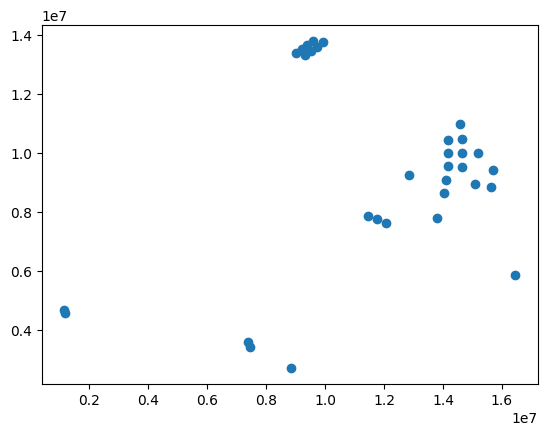

In [93]:
geo_df_utm_final['geometry'].plot()

In [94]:
# Create a dictionary to store distances in the Projected Coordinate System (PCS)
pcs_distance_dict = {}

# Calculate distances for each pair of places using the built-in distance function in GeoPandas
for i, row1 in geo_df_utm_final.iterrows():
    for j, row2 in geo_df_utm_final.iterrows():
        if i < j:
            place1 = row1['place_slug']
            place2 = row2['place_slug']

            # Calculate distance in meters using the built-in distance function
            distance_meters = row1['geometry'].distance(row2['geometry'])

            # Convert distance to kilometers
            distance_km = distance_meters / 1000

            # Store the calculated distance
            pcs_distance_dict[f"{place1} to {place2}"] = round(distance_km, 2)

pcs_distance_dict

{'mumbai-india to chiang-mai-thailand': 7933.33,
 'mumbai-india to ko-lanta-thailand': 9339.42,
 'mumbai-india to bangkok-thailand': 7660.4,
 'mumbai-india to mumbai-india': 183.1,
 'mumbai-india to cambodia': 9406.1,
 'mumbai-india to pai-thailand': 6233.01,
 'mumbai-india to sofia-bulgaria': 6400.68,
 'mumbai-india to bangalore-india': 1552.8,
 'mumbai-india to jakarta-indonesia': inf,
 'mumbai-india to taiwan': 10610.24,
 'chiang-mai-thailand to ko-lanta-thailand': 5060.07,
 'chiang-mai-thailand to bangkok-thailand': 2040.06,
 'chiang-mai-thailand to mumbai-india': 6091.41,
 'chiang-mai-thailand to cambodia': 2253.75,
 'chiang-mai-thailand to pai-thailand': 1797.53,
 'chiang-mai-thailand to chiang-mai-thailand': 1856.44,
 'chiang-mai-thailand to sofia-bulgaria': 12586.08,
 'chiang-mai-thailand to bangalore-india': 7662.78,
 'chiang-mai-thailand to jakarta-indonesia': inf,
 'chiang-mai-thailand to taiwan': 5358.7,
 'ko-lanta-thailand to bangkok-thailand': 3279.89,
 'ko-lanta-thailand